In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot

In [2]:
dt = "20250103"
nrows = 10000000
df = pd.read_csv(f"market/xnas-itch-{dt}.mbp-10.csv", nrows=nrows)
trddf = pd.read_csv(f"market/xnas-itch-{dt}.trades.csv", nrows=nrows)

df.head()

,ts_recv,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
0,2025-01-03T09:00:00.015869440Z,2025-01-03T09:00:00.015702539Z,10,2,11667,A,N,0,140.97,100,...,0,0,0,NaN,NaN,0,0,0,0,NVDA
1,2025-01-03T09:00:00.015938794Z,2025-01-03T09:00:00.015771793Z,10,2,11667,A,B,0,137.50,10000,...,0,0,0,NaN,NaN,0,0,0,0,NVDA
2,2025-01-03T09:00:00.040850395Z,2025-01-03T09:00:00.040665733Z,10,2,11667,A,A,1,157.05,73,...,0,0,0,NaN,NaN,0,0,0,0,NVDA
3,2025-01-03T09:00:00.059865276Z,2025-01-03T09:00:00.059698561Z,10,2,11667,A,A,0,138.81,1000,...,0,0,0,NaN,NaN,0,0,0,0,NVDA
4,2025-01-03T09:00:00.085513156Z,2025-01-03T09:00:00.085346759Z,10,2,11667,A,B,1,121.00,20,...,0,0,0,NaN,NaN,0,0,0,0,NVDA


In [3]:
df.columns

Index(['ts_recv', 'ts_event', 'rtype', 'publisher_id', 'instrument_id',
       'action', 'side', 'depth', 'price', 'size', 'flags', 'ts_in_delta',
       'sequence', 'bid_px_00', 'ask_px_00', 'bid_sz_00', 'ask_sz_00',
       'bid_ct_00', 'ask_ct_00', 'bid_px_01', 'ask_px_01', 'bid_sz_01',
       'ask_sz_01', 'bid_ct_01', 'ask_ct_01', 'bid_px_02', 'ask_px_02',
       'bid_sz_02', 'ask_sz_02', 'bid_ct_02', 'ask_ct_02', 'bid_px_03',
       'ask_px_03', 'bid_sz_03', 'ask_sz_03', 'bid_ct_03', 'ask_ct_03',
       'bid_px_04', 'ask_px_04', 'bid_sz_04', 'ask_sz_04', 'bid_ct_04',
       'ask_ct_04', 'bid_px_05', 'ask_px_05', 'bid_sz_05', 'ask_sz_05',
       'bid_ct_05', 'ask_ct_05', 'bid_px_06', 'ask_px_06', 'bid_sz_06',
       'ask_sz_06', 'bid_ct_06', 'ask_ct_06', 'bid_px_07', 'ask_px_07',
       'bid_sz_07', 'ask_sz_07', 'bid_ct_07', 'ask_ct_07', 'bid_px_08',
       'ask_px_08', 'bid_sz_08', 'ask_sz_08', 'bid_ct_08', 'ask_ct_08',
       'bid_px_09', 'ask_px_09', 'bid_sz_09', 'ask_sz_09', 'bi

#### Adjust timestamps

In [11]:
df["ts_event"] = pd.to_datetime(df.ts_event, unit="ns", )
df["ts_event"] = df["ts_event"].dt.tz_convert('US/Eastern')
df = df[df["ts_event"].dt.time >= pd.to_datetime("09:30").time()]
df = df[df["ts_event"].dt.time <= pd.to_datetime("16:00").time()]


#### Cleanup (drop rows with NA)

In [12]:
orig_len = df.shape[0]
df.dropna(inplace=True)
cur_len = df.shape[0]
drop_cnt = orig_len-cur_len
if  drop_cnt > 1000:
    raise Exception(f"{drop_cnt} rows dropped, seems a lot")
else:
    print(f"{drop_cnt} dropped out of {orig_len}")

0 dropped out of 3999187


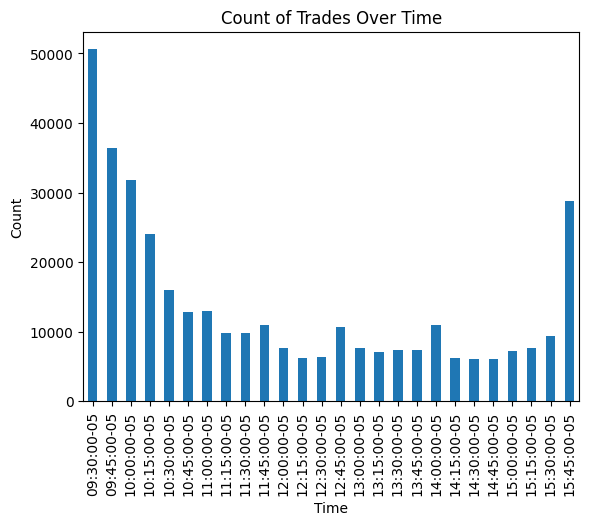

In [14]:
# Filter the dataframe for action "T"
df_trades = df[df['action'] == "T"]

# Group by buckets of 15 minutes
df_trades.set_index('ts_event').resample('15min').size().plot(kind='bar', title='Count of Trades Over Time')
plot.xlabel('Time')
#plot.xticks(rotation=45)
labels = [item.get_text().split(' ')[1].split('+')[0][:-3] for item in plot.gca().get_xticklabels()]
plot.gca().set_xticklabels(labels)
plot.ylabel('Count')
plot.show()

In [57]:
trades = df[(df.action == "T") & (df.side != "N")]
cols = ["action", "side", "price", "size", "bid_sz_00", "bid_px_00", "ask_px_00", "ask_sz_00",
         "bid_sz_01", "bid_px_01", "ask_px_01", "ask_sz_01","sequence"]
trades.side.value_counts()


side
B    154383
A    134000
Name: count, dtype: int64

In [58]:
def display_around(idx, nbrows=6):
    return df.loc[idx-1:idx+nbrows-1][cols]
idx = 0

In [87]:
x = display_around(trades.index[idx])
print(idx, trades.index[idx])
idx = idx + 1
x

27 80933


,action,side,price,size,bid_sz_00,bid_px_00,ask_px_00,ask_sz_00,bid_sz_01,bid_px_01,ask_px_01,ask_sz_01,sequence
80932,A,A,139.98,100,6,139.95,139.98,200,106,139.94,139.99,40,22022390
80933,T,A,139.95,6,6,139.95,139.98,200,106,139.94,139.99,40,22022559
80934,C,B,139.95,6,106,139.94,139.98,200,500,139.90,139.99,40,22022559
80935,C,B,139.94,50,56,139.94,139.98,200,500,139.90,139.99,40,22022598
80936,A,A,139.96,80,56,139.94,139.96,80,500,139.90,139.97,100,22022614
80937,T,A,139.94,21,56,139.94,139.96,80,500,139.90,139.97,100,22022643
80938,T,A,139.94,13,35,139.94,139.96,80,500,139.90,139.97,100,22022644


### calculate imbalance

In [23]:
def calc_bid_weight(row):
    return  np.array([row['mid']/(row['mid']-row[f'bid_px_0{i}'])*row[f'bid_sz_0{i}'] for i in range(0,10)]).sum(axis=0)
def calc_ask_weight(row): 
    return np.array([row['mid']/(row[f'ask_px_0{i}']-row['mid'])*row[f'ask_sz_0{i}'] for i in range(0,10)]).sum(axis=0)    

In [24]:
# want to calculate the amount but also how spread out it is
df['mid'] = (df['bid_px_00']+df['ask_px_00'])/2
df['bid_weight'] = calc_bid_weight(df)
df['ask_weight'] = calc_ask_weight(df)
df['bid_weight_log'] = np.log(df['bid_weight'])
df['ask_weight_log'] = np.log(df['ask_weight'])

df[['bid_weight', 'ask_weight', 'bid_weight_log', 'ask_weight_log']].describe()

,bid_weight,ask_weight,bid_weight_log,ask_weight_log
count,3.999187e+06,3.999187e+06,3.999187e+06,3.999187e+06
mean,4.231951e+07,7.779665e+07,1.729345e+01,1.748269e+01
std,6.232995e+07,2.119649e+08,6.640693e-01,9.463023e-01
min,1.238872e+06,6.444875e+05,1.402971e+01,1.337621e+01
25%,2.172110e+07,2.121488e+07,1.689379e+01,1.687021e+01
50%,3.214055e+07,3.323096e+07,1.728563e+01,1.731899e+01
75%,4.693496e+07,6.015972e+07,1.766427e+01,1.791251e+01
max,4.663111e+09,1.012570e+10,2.226295e+01,2.303834e+01


### In search of one order triggering more than one execution

In [184]:
df[(df.action == "T") & (df.side == "B") & 
   (df.shift(1)["ask_px_00"] != df["ask_px_00"])][cols].head()
#   & ((df.shift(-1)["ask_px_00"] == df["ask_px_00"] ) & (df.shift(-1)["ask_sz_00"] == df["ask_sz_00"]-df["size"]))][cols].head()
      

,action,side,price,size,bid_sz_00,bid_px_00,ask_px_00,ask_sz_00,bid_sz_01,bid_px_01,ask_px_01,ask_sz_01,sequence
888,T,B,134.44,27,3,134.30,134.44,500,313,134.29,134.45,1902,332209
4946,T,B,135.27,48,250,135.20,135.27,109,1725,135.17,135.40,500,619300
6906,T,B,135.20,100,1067,135.17,135.20,100,600,135.09,135.30,500,860949
7993,T,B,135.29,52,640,135.20,135.29,108,1000,135.10,135.30,152,1062146
8011,T,B,135.32,30,52,135.24,135.32,52,186,135.21,135.33,57,1062214


In [185]:
display_around(882, 10)

,action,side,price,size,bid_sz_00,bid_px_00,ask_px_00,ask_sz_00,bid_sz_01,bid_px_01,ask_px_01,ask_sz_01,sequence
1019,C,A,134.45,1,100,134.32,134.45,845,214,134.31,134.5,8500,333110
1020,T,B,134.45,400,100,134.32,134.45,845,214,134.31,134.5,8500,333121
1021,C,A,134.45,400,100,134.32,134.45,445,214,134.31,134.5,8500,333121
1022,T,B,134.45,18,100,134.32,134.45,445,214,134.31,134.5,8500,333122
1023,C,A,134.45,18,100,134.32,134.45,427,214,134.31,134.5,8500,333122
1024,T,B,134.45,3,100,134.32,134.45,427,214,134.31,134.5,8500,333123
1025,C,A,134.45,3,100,134.32,134.45,424,214,134.31,134.5,8500,333123
1026,T,B,134.45,29,100,134.32,134.45,424,214,134.31,134.5,8500,333124
1027,C,A,134.45,29,100,134.32,134.45,395,214,134.31,134.5,8500,333124
1028,T,B,134.45,5,100,134.32,134.45,395,214,134.31,134.5,8500,333125


In [186]:
df[(df.action == "T") & (df.side != "N") & (df.shift(-1).action != "C")][cols]

,action,side,price,size,bid_sz_00,bid_px_00,ask_px_00,ask_sz_00,bid_sz_01,bid_px_01,ask_px_01,ask_sz_01,sequence
143,T,B,134.80,1,300,134.61,134.80,1,1000,134.40,135.08,400,300502
206,T,A,135.08,2,4,135.08,135.13,400,100,134.98,135.22,10,302725
207,T,A,135.08,2,2,135.08,135.13,400,100,134.98,135.22,10,302726
222,T,A,134.98,100,100,134.98,135.10,400,1000,134.70,135.11,100,303163
243,T,B,134.81,79,100,134.64,134.81,179,207,134.62,135.04,100,303231
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999842,T,A,138.01,100,118,138.01,138.03,525,255,138.00,138.04,625,151584832
999843,T,A,138.01,8,18,138.01,138.03,525,255,138.00,138.04,625,151584833
999943,T,A,138.00,10,23,138.00,138.02,425,225,137.99,138.03,425,151595583
999944,T,A,138.00,3,13,138.00,138.02,425,225,137.99,138.03,425,151595584


In [187]:
display_around(206)

,action,side,price,size,bid_sz_00,bid_px_00,ask_px_00,ask_sz_00,bid_sz_01,bid_px_01,ask_px_01,ask_sz_01,sequence
343,A,B,134.10,1000,100,134.64,135.09,606,107,134.62,135.22,10,304963
344,C,B,134.00,1000,100,134.64,135.09,606,107,134.62,135.22,10,304976
345,A,B,133.70,1000,100,134.64,135.09,606,107,134.62,135.22,10,304989
346,C,B,133.40,1000,100,134.64,135.09,606,107,134.62,135.22,10,304990
347,C,A,135.09,100,100,134.64,135.09,506,107,134.62,135.22,10,305627
348,C,A,135.70,1000,100,134.64,135.09,506,107,134.62,135.22,10,305676


In [188]:
trade_indices = trades.index
next_trade_indices = trade_indices + 1

# Filter out indices that are not present in df
valid_indices = next_trade_indices[next_trade_indices.isin(df.index)]

# Perform the subtraction only on valid indices
df["diff"] = df.apply(lambda row: row['size'] - df['size'].shift(-1)[row.name] if row['action'] =="T" else 0, axis=1)
df[df["diff"] != 0][cols + ["diff"]].head()


KeyboardInterrupt: 

In [148]:
multi = df[df["diff"] != 0]
multi[cols + ["diff"]].head()
idx = multi.iloc[0].name
df.iloc[idx-1:idx+10][cols]


IndexError: single positional indexer is out-of-bounds

In [40]:
df.iloc[25:35][cols]

,action,side,price,size,bid_sz_00,bid_px_00,ask_px_00,ask_sz_00,bid_sz_01,bid_px_01,ask_px_01,ask_sz_01,sequence
25,C,B,134.30,34,1864,134.30,135.19,11,2000,134.2,136.20,1000,290506
26,T,N,134.31,6,1864,134.30,135.19,11,2000,134.2,136.20,1000,290508
27,T,N,134.31,1,1864,134.30,135.19,11,2000,134.2,136.20,1000,290509
28,T,N,134.31,1,1864,134.30,135.19,11,2000,134.2,136.20,1000,290524
29,T,A,134.30,7,1864,134.30,135.19,11,2000,134.2,136.20,1000,290525
30,C,B,134.30,7,1857,134.30,135.19,11,2000,134.2,136.20,1000,290525
31,A,B,134.50,2000,2000,134.50,135.19,11,1857,134.3,136.20,1000,290709
32,A,B,134.40,2000,2000,134.50,135.19,11,2000,134.4,136.20,1000,290765
33,A,A,135.12,400,2000,134.50,135.12,400,2000,134.4,135.19,11,292351
34,A,B,134.89,100,100,134.89,135.12,400,2000,134.5,135.19,11,292388


### In search of iceberg orders

In [41]:
ask_trade_indices = trades[trades["side"] == "A"].index
next_ask_trade_indices = ask_trade_indices + 1
#trades.loc[following[:10]][cols]
df.loc[[6,7]][cols]

diff = df.loc[following, ""][cols].diff()

NameError: name 'following' is not defined